In [1]:
!pip install nlpaug
!pip install nltk
!pip install sacremoses
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 8.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
import pandas as pd
import accelerate
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import MarianMTModel, MarianTokenizer
from datasets import Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
import math
import copy
import random
import operator
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf
import time
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from transformers.modeling_outputs import TokenClassifierOutput
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
columns = ['id', 'identifier', 'category', 'country_code', 'text', 'multi_label']

try:
    data_df = pd.read_csv("/content/dontpatronizeme_pcl.tsv", sep='\t', header=None, names=columns, skiprows=3, index_col='id')
except pd.errors.ParserError as e:
    print("ParserError:", e)

data_df['label'] = data_df['multi_label'].apply(lambda x: 0 if x == 0 or x == 1 else 1)
data_df = data_df.dropna()
data_df["text_length"] = data_df["text"].apply(lambda x: len(x))

In [4]:
train_ids = pd.read_csv("/content/train_semeval_parids-labels.csv")
dev_ids = pd.read_csv("/content/dev_semeval_parids-labels.csv")

In [5]:
train_df = pd.read_csv("/content/bestprocaug.csv")
dev_df = data_df.loc[data_df.index.isin(dev_ids['par_id'])]

In [6]:
train_df

,id,identifier,category,country_code,text,multi_label,label,text_length
0,1,@@24942188,hopeless,ph,"We 're living in time of absolute insanity , a...",0,0,620
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,237
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0,158
3,4,@@7811231,disabled,nz,Council customer only sign would be displayed ...,0,0,162
4,5,@@1494111,refugee,ca,`` Just like we received migrant fleeing El Sa...,0,0,273
...,...,...,...,...,...,...,...,...
11546,10424,@@4665292,women,jm,` ` i do not entirely believe in artificial ab...,3,1,133
11547,10445,@@3923193,refugee,gb,much more you than cl voluntary monks spend th...,3,1,112
11548,10454,@@22338535,vulnerable,ie,"` ` here are your challenged, i, turn this clo...",4,1,240
11549,10467,@@20282330,in-need,ng,"` ` she one with huge platform, and informatio...",3,1,282


In [6]:
dev_df

,identifier,category,country_code,text,multi_label,label,text_length
id,,,,,,,
107,@@16900972,homeless,ke,"His present "" chambers "" may be quite humble ,...",3,1,394
149,@@1387882,disabled,us,Krueger recently harnessed that creativity to ...,2,1,296
151,@@19974860,poor-families,in,10:41am - Parents of children who died must ge...,3,1,138
154,@@20663936,disabled,ng,When some people feel causing problem for some...,4,1,496
157,@@21712008,poor-families,ca,We are alarmed to learn of your recently circu...,4,1,601
...,...,...,...,...,...,...,...
10463,@@4676355,refugee,pk,""" The Pakistani police came to our house and t...",0,0,166
10464,@@19612634,disabled,ie,When Marie O'Donoghue went looking for a speci...,0,0,199
10465,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0,344


In [21]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

class MultimodalModel(nn.Module):
    def __init__(self, num_categories=10, num_countries=20, num_epochs=1):
        super(MultimodalModel, self).__init__()
        self.num_labels = 2  # binary classification
        self.id2label = {0: "NEGATIVE", 1: "POSITIVE"}
        self.label2id = {"NEGATIVE": 0, "POSITIVE": 1}

        # Initialize tokenizer and base RoBERTa model
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=self.num_labels, id2label=self.id2label, label2id=self.label2id)

        self.category_embedding = nn.Embedding(num_embeddings=num_categories, embedding_dim=4)
        self.country_embedding = nn.Embedding(num_embeddings=num_countries, embedding_dim=4)

        self.text_length_linear = nn.Linear(1, 4)

        self.combined_fc = nn.Linear(768 + 4 + 4 + 4, 512)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(512, self.num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

        self.train_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=num_epochs,
            per_device_train_batch_size=64,
            per_device_eval_batch_size=128,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            evaluation_strategy='epoch',
            learning_rate=5e-5
        )

    def apply_tokenizer(self, batch):
        tokenized_inputs = self.tokenizer(
            batch["text"],
            truncation=True,
            padding=True,
            max_length=100,
            add_special_tokens=True,
        )

        tokenized_inputs['category_num'] = batch['category_num']
        tokenized_inputs['country_num'] = batch['country_num']
        tokenized_inputs['text_length'] = [[length] for length in batch['text_length']]

        return tokenized_inputs


    def compute_metrics(self, pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average="binary"
        )
        acc = accuracy_score(labels, preds)
        return {
            "accuracy": acc,
            "f1": f1,
            "precision": precision,
            "recall": recall,
        }

    def forward(self, input_ids, attention_mask=None, categories=None, countries=None, text_lengths=None, labels=None):

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        category_features = self.category_embedding(categories)
        country_features = self.country_embedding(countries)

        text_length_features = self.text_length_linear(text_lengths.view(-1, 1))
        combined_features = torch.cat((pooled_output, category_features, country_features, text_length_features), dim=1)
        combined_features = self.dropout(combined_features)

        logits = self.classifier(combined_features)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels.view(-1))

        return logits, loss

    def train(self, train_df, dev_df):
        train_hf = Dataset.from_pandas(train_df)
        dev_hf = Dataset.from_pandas(dev_df)

        tokenized_train = train_hf.map(self.apply_tokenizer, batched=True)
        tokenized_dev = dev_hf.map(self.apply_tokenizer, batched=True)

        self.trainer = Trainer(
            model=self.model,
            args=self.train_args,
            tokenizer=self.tokenizer,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_dev,
            compute_metrics=self.compute_metrics
        )

        self.trainer.train()

    def evaluate_train(self, train_df):
        input_hf = Dataset.from_pandas(train_df)
        tokenized_input = input_hf.map(self.apply_tokenizer, batched=True)
        return self.trainer.evaluate(tokenized_input)

    def evaluate_dev(self):
        return self.trainer.evaluate()

    def predict_out(self, df):
        input_hf = Dataset.from_pandas(df)
        tokenized_input = input_hf.map(self.apply_tokenizer, batched=True)
        predictions = self.trainer.predict(tokenized_input)
        return predictions.predictions


In [7]:
train_df["country_num"] = pd.Categorical(train_df['country_code']).codes
dev_df["country_num"] = pd.Categorical(dev_df['country_code']).codes
train_df['category_num'] = pd.Categorical(train_df['category']).codes
dev_df['category_num'] = pd.Categorical(dev_df['category']).codes

<ipython-input-7-198d7ffbd1c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["country_num"] = pd.Categorical(dev_df['country_code']).codes
<ipython-input-7-198d7ffbd1c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['category_num'] = pd.Categorical(dev_df['category']).codes


In [22]:
model =  MultimodalModel(num_epochs=5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model.train(train_df, dev_df)

Map:   0%|          | 0/11551 [00:00<?, ? examples/s]

Map:   0%|          | 0/2093 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.159500,0.232309,0.909221,0.201681,0.615385,0.120603
2,0.167900,0.231109,0.914477,0.353791,0.628205,0.246231
3,0.123300,0.240460,0.916866,0.571429,0.560386,0.582915
4,0.054500,0.260105,0.921166,0.495413,0.632812,0.407035
5,0.013600,0.356505,0.930721,0.564565,0.701493,0.472362


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


In [24]:
model.evaluate_train(train_df)

Map:   0%|          | 0/11551 [00:00<?, ? examples/s]

{'eval_loss': 0.010786599479615688,
 'eval_accuracy': 0.9974028222664705,
 'eval_f1': 0.9962149886449659,
 'eval_precision': 0.9979777553083923,
 'eval_recall': 0.9944584382871536,
 'eval_runtime': 20.4204,
 'eval_samples_per_second': 565.661,
 'eval_steps_per_second': 4.456,
 'epoch': 5.0}

In [25]:
model.evaluate_dev()

{'eval_loss': 0.35650473833084106,
 'eval_accuracy': 0.9307214524605829,
 'eval_f1': 0.5645645645645645,
 'eval_precision': 0.7014925373134329,
 'eval_recall': 0.4723618090452261,
 'eval_runtime': 3.5175,
 'eval_samples_per_second': 595.033,
 'eval_steps_per_second': 4.833,
 'epoch': 5.0}

In [42]:
torch.save(model.state_dict(), '/content/final_model.pth')

In [30]:
dev_preds = model.predict_out(dev_df[['text', 'country_num','category_num','text_length']])

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/2093 [00:00<?, ? examples/s]

In [32]:
probs = torch.softmax(torch.tensor(dev_preds), dim=-1)
predicted_labels = torch.argmax(probs, dim=-1).numpy()
predicted_labels

array([0, 0, 0, ..., 0, 0, 1])

In [11]:
truth_labels = dev_df['label'].to_numpy()

In [12]:
from sklearn.metrics import f1_score
f1 = f1_score(truth_labels, predicted_labels)

In [13]:
f1

0.5645645645645645

In [41]:
with open('/content/dev.txt', 'w') as file:
    for pred in predicted_labels:
        file.write(str(pred) + '\n')

In [48]:
columns = ['id', 'identifier', 'category', 'country_code', 'text']
test_df = pd.read_csv("/content/task4_test.tsv", sep="\t", names=columns)
test_df["text_length"] = test_df["text"].apply(lambda x: len(x))
test_df["country_num"] = pd.Categorical(test_df['country_code']).codes
test_df['category_num'] = pd.Categorical(test_df['category']).codes


In [49]:
test_df.head()

,id,identifier,category,country_code,text,text_length,country_num,category_num
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to...",238,18,8
1,t_1,@@16397324,women,pk,In most poor households with no education chil...,316,15,9
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...,203,2,5
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population...",90,3,5
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C...",245,2,8


In [50]:
test_preds = model.predict_out(test_df[['text', 'country_num','category_num','text_length']])

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

In [51]:
test_probs = torch.softmax(torch.tensor(test_preds), dim=-1)
predicted_labels_test = torch.argmax(test_probs, dim=-1).numpy()
predicted_labels_test

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
with open('/content/test.txt', 'w') as file:
    for pred in predicted_labels_test:
        file.write(str(pred) + '\n')

## Analysis of F1 score with respect to different columns of the dataset

### Severity of PCL

In [14]:
dev_df['predicted_labels'] = predicted_labels

<ipython-input-14-54a868967d85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['predicted_labels'] = predicted_labels


In [15]:
dev_df

,identifier,category,country_code,text,multi_label,label,text_length,country_num,category_num,predicted_labels
id,,,,,,,,,,
107,@@16900972,homeless,ke,"His present "" chambers "" may be quite humble ,...",3,1,394,9,1,0
149,@@1387882,disabled,us,Krueger recently harnessed that creativity to ...,2,1,296,18,0,0
151,@@19974860,poor-families,in,10:41am - Parents of children who died must ge...,3,1,138,7,6,0
154,@@20663936,disabled,ng,When some people feel causing problem for some...,4,1,496,12,0,1
157,@@21712008,poor-families,ca,We are alarmed to learn of your recently circu...,4,1,601,2,6,0
...,...,...,...,...,...,...,...,...,...,...
10463,@@4676355,refugee,pk,""" The Pakistani police came to our house and t...",0,0,166,15,7,0
10464,@@19612634,disabled,ie,When Marie O'Donoghue went looking for a speci...,0,0,199,6,0,0
10465,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0,344,10,9,0


In [16]:
pcl_dev_df = dev_df[dev_df['label']==1]

In [17]:
pcl_dev_df.head()

,identifier,category,country_code,text,multi_label,label,text_length,country_num,category_num,predicted_labels
id,,,,,,,,,,
107,@@16900972,homeless,ke,"His present "" chambers "" may be quite humble ,...",3,1,394,9,1,0
149,@@1387882,disabled,us,Krueger recently harnessed that creativity to ...,2,1,296,18,0,0
151,@@19974860,poor-families,in,10:41am - Parents of children who died must ge...,3,1,138,7,6,0
154,@@20663936,disabled,ng,When some people feel causing problem for some...,4,1,496,12,0,1
157,@@21712008,poor-families,ca,We are alarmed to learn of your recently circu...,4,1,601,2,6,0


In [19]:
label_4, predicted_label_4 = pcl_dev_df[pcl_dev_df['multi_label']==4]['label'].to_numpy(),  pcl_dev_df[pcl_dev_df['multi_label']==4]['predicted_labels'].to_numpy()

In [34]:
f1_4 = f1_score(label_4, predicted_label_4)


In [21]:
label_3, predicted_label_3 = pcl_dev_df[pcl_dev_df['multi_label']==3]['label'].to_numpy(),  pcl_dev_df[pcl_dev_df['multi_label']==3]['predicted_labels'].to_numpy()

In [35]:
f1_3 = f1_score(label_3, predicted_label_3)


In [23]:
label_2, predicted_label_2 = pcl_dev_df[pcl_dev_df['multi_label']==2]['label'].to_numpy(),  pcl_dev_df[pcl_dev_df['multi_label']==2]['predicted_labels'].to_numpy()

In [36]:
f1_2 = f1_score(label_2, predicted_label_2)


In [25]:
no_pcl_dev_df = dev_df[dev_df['label']==0]

In [26]:
label_1, predicted_label_1 = dev_df[dev_df['multi_label']==1]['label'].to_numpy(),  dev_df[dev_df['multi_label']==1]['predicted_labels'].to_numpy()

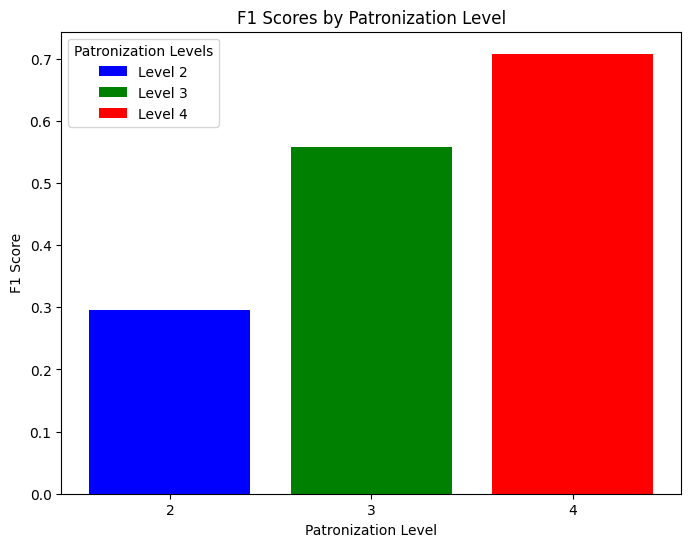

In [27]:
import matplotlib.pyplot as plt

f1_scores = [f1_2, f1_3, f1_4]
levels = ['2', '3', '4']
colors = ['blue', 'green', 'red']

plt.figure(figsize=(8, 6))
bars = plt.bar(levels, f1_scores, color=colors)

plt.title('F1 Scores by Patronization Level')
plt.xlabel('Patronization Level')
plt.ylabel('F1 Score')

legend_labels = ['Level 2', 'Level 3', 'Level 4']
plt.legend(bars, legend_labels, title="Patronization Levels")
plt.show()

### Performance with Data Categories

In [28]:
dev_df

,identifier,category,country_code,text,multi_label,label,text_length,country_num,category_num,predicted_labels
id,,,,,,,,,,
107,@@16900972,homeless,ke,"His present "" chambers "" may be quite humble ,...",3,1,394,9,1,0
149,@@1387882,disabled,us,Krueger recently harnessed that creativity to ...,2,1,296,18,0,0
151,@@19974860,poor-families,in,10:41am - Parents of children who died must ge...,3,1,138,7,6,0
154,@@20663936,disabled,ng,When some people feel causing problem for some...,4,1,496,12,0,1
157,@@21712008,poor-families,ca,We are alarmed to learn of your recently circu...,4,1,601,2,6,0
...,...,...,...,...,...,...,...,...,...,...
10463,@@4676355,refugee,pk,""" The Pakistani police came to our house and t...",0,0,166,15,7,0
10464,@@19612634,disabled,ie,When Marie O'Donoghue went looking for a speci...,0,0,199,6,0,0
10465,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0,344,10,9,0


In [29]:
category_nums = [0,1,2,3,4,5,6,7,8,9]
categories = ['disabled', 'homeless', 'hopeless', 'immigrant', 'in-need', 'migrant', 'poor-families', 'refugee', 'vulnerable', 'women']
f1_scores = []
proportions = []
for c_num in category_nums:
  truth = dev_df[dev_df['category_num'] == c_num]['label']
  pred = dev_df[dev_df['category_num'] == c_num]['predicted_labels']
  proportions.append(len(train_df[train_df['category_num'] == 0][train_df['label'] == 1]) / len(train_df[train_df['category_num'] == c_num][train_df['label'] == 0]))
  f1_scores.append(f1_score(truth, pred))

<ipython-input-29-9bc2785b5da3>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  proportions.append(len(train_df[train_df['category_num'] == 0][train_df['label'] == 1]) / len(train_df[train_df['category_num'] == c_num][train_df['label'] == 0]))
<ipython-input-29-9bc2785b5da3>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  proportions.append(len(train_df[train_df['category_num'] == 0][train_df['label'] == 1]) / len(train_df[train_df['category_num'] == c_num][train_df['label'] == 0]))
<ipython-input-29-9bc2785b5da3>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  proportions.append(len(train_df[train_df['category_num'] == 0][train_df['label'] == 1]) / len(train_df[train_df['category_num'] == c_num][train_df['label'] == 0]))
<ipython-input-29-9bc2785b5da3>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  proportions.append(len(train_df[train_df['category_num']

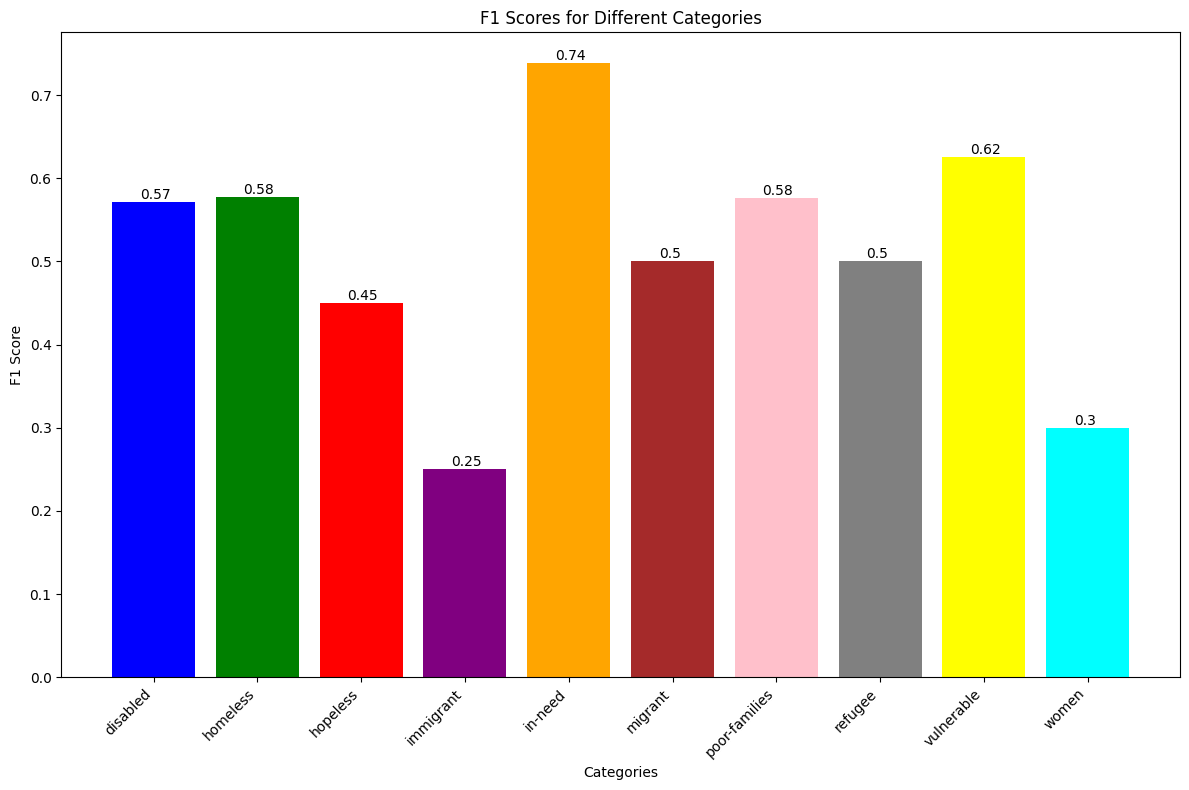

In [30]:
# Creating the bar plot
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan']
bars = plt.bar(categories, f1_scores, color=colors)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Different Categories')
plt.xticks(rotation=45, ha="right")  # Rotate category names for better readability

# Adding the F1 score above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 3.0, yval, round(yval,2), va='bottom')  # va: vertical alignment

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated category names
plt.show()

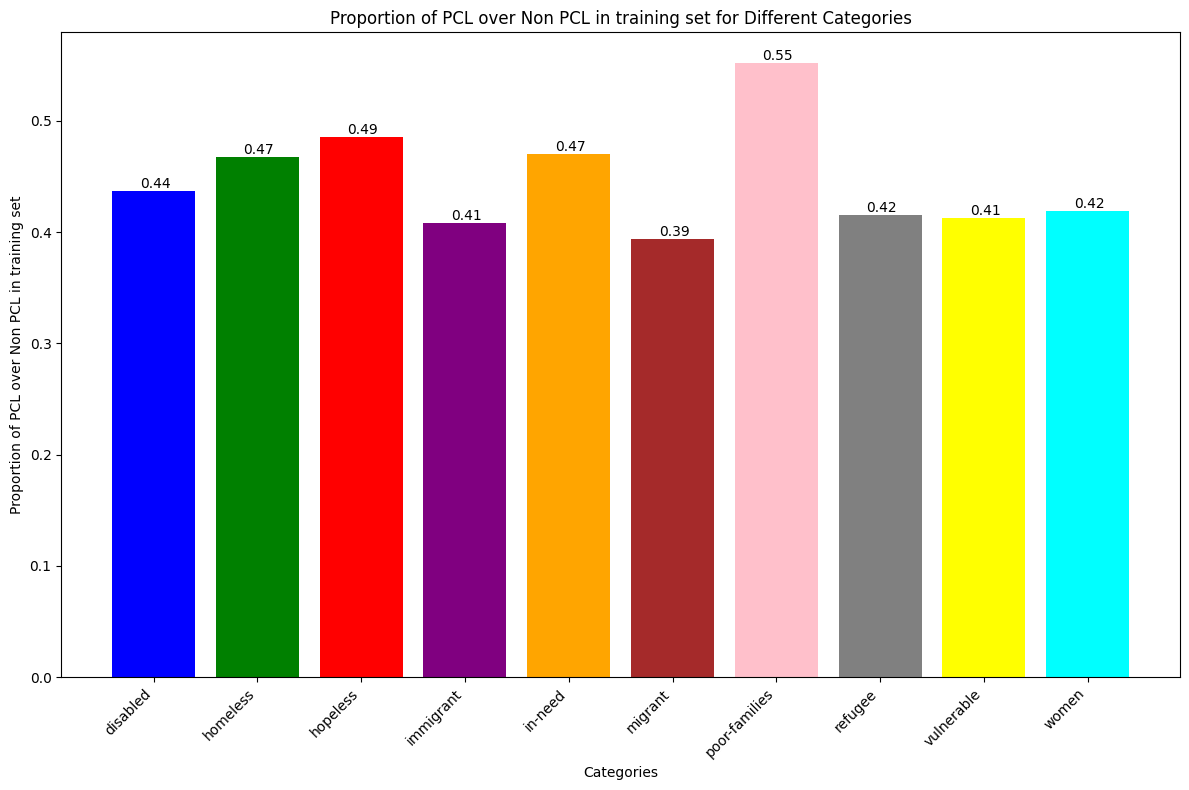

In [31]:
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan']

bars = plt.bar(categories, proportions, color=colors)

plt.xlabel('Categories')
plt.ylabel('Proportion of PCL over Non PCL in training set')
plt.title('Proportion of PCL over Non PCL in training set for Different Categories')
plt.xticks(rotation=45, ha="right")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 3.0, yval, round(yval,2), va='bottom')

plt.tight_layout()
plt.show()

#### Text Length and Performance

In [32]:
lengths = ['Below 50', '50 to 120', '120 to 200', 'over 200']
ls = [50,120,200,10000]
f1_scores = []

for i, l in enumerate(ls):
  if i == 0:
    truth = dev_df[dev_df['text_length'] < l]['label']
    pred = dev_df[dev_df['text_length'] < l]['predicted_labels']
  else:
    truth = dev_df[(dev_df['text_length'] < l) & (dev_df['text_length'] >= ls[i-1])]['label']
    pred = dev_df[(dev_df['text_length'] < l) & (dev_df['text_length'] >= ls[i-1])]['predicted_labels']

  f1_scores.append(f1_score(truth, pred))

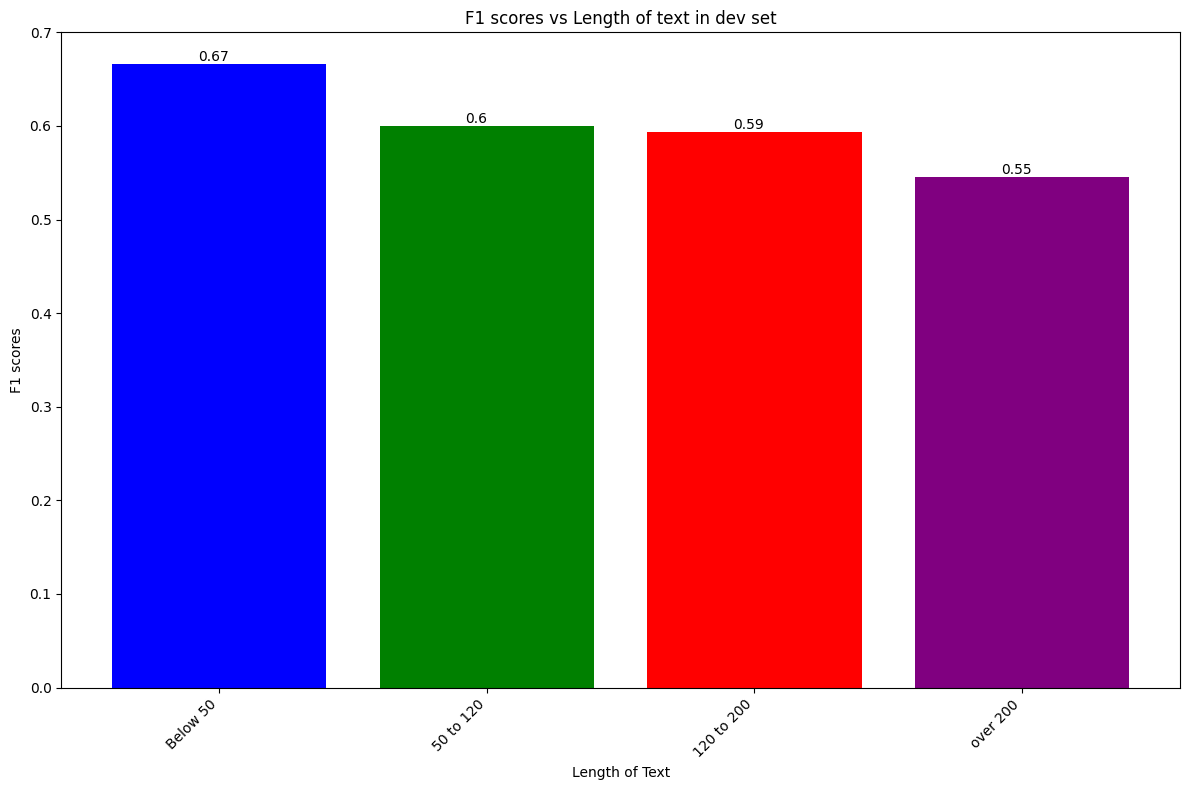

In [33]:
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']
bars = plt.bar(lengths, f1_scores, color=colors)

plt.xlabel('Length of Text')
plt.ylabel('F1 scores')
plt.title('F1 scores vs Length of text in dev set')
plt.xticks(rotation=45, ha="right")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.5, yval, round(yval,2), va='bottom')

plt.tight_layout()
plt.show()